In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib xgboost lightgbm imbalanced-learn shap




In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown


In [18]:


# Load and Inspect Dataset
data = pd.read_csv('/content/Thyroid_Diff.csv')  # Update path as per your environment

# Display Dataset Preview as a Table
print("Dataset Preview:")
display(data.head())  # Displays the first 5 rows of the dataset in table format

# Display Columns in the Dataset as a Table
print("\nColumns in the dataset:")
columns_df = pd.DataFrame(data.columns, columns=['Column Names'])
display(columns_df)  # Displays the column names in table format


Dataset Preview:


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No



Columns in the dataset:


,Column Names
0,Age
1,Gender
2,Smoking
3,Hx Smoking
4,Hx Radiothreapy
5,Thyroid Function
6,Physical Examination
7,Adenopathy
8,Pathology
9,Focality


No charts were generated by quickchart


In [19]:
# Define and Check Target Column
def check_target_column(data, target_column):
    if target_column not in data.columns:
        raise ValueError(f"Error: The column '{target_column}' does not exist in the dataset. Available columns are: {data.columns.tolist()}")
    print(f"Target column '{target_column}' found in the dataset.")

target_column = 'Recurred'
check_target_column(data, target_column)

# Handle Missing Values Automatically
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
data[numerical_columns] = imputer_num.fit_transform(data[numerical_columns])

imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = imputer_cat.fit_transform(data[categorical_columns])

print("Missing values in each column after imputation:")
print(data.isnull().sum())

# Encode Categorical Variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


Target column 'Recurred' found in the dataset.
Missing values in each column after imputation:
Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


In [24]:
# Feature Engineering and Selection
print("\n# Feature Engineering and Selection")
data['Age_Smoking'] = data['Age'] * data['Smoking']  # Example feature interaction

X = data.drop(columns=[target_column])
y = data[target_column]

model_for_selection = RandomForestClassifier()
selector = RFE(model_for_selection, n_features_to_select=10, step=1)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Feature Engineering and Selection

# Define Models and Hyperparameter Grids


In [32]:
# Define Models and Hyperparameter Grids
print("\n# Define Models and Hyperparameter Grids")

# Define models and their respective hyperparameter grids for tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators': [50, 100], 'max_depth': [3, 6]}
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}  # No hyperparameters to tune
    }
}

# Train and Evaluate Models with Hyperparameter Tuning
print("\n# Train and Evaluate Models with Hyperparameter Tuning")
results = {}

# Iterate through each model and its parameters
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['params']

    print(f"Training and evaluating {model_name}...")

    try:
        # If there are parameters to tune, use RandomizedSearchCV for hyperparameter tuning
        if param_grid:
            search = RandomizedSearchCV(
                model,
                param_distributions=param_grid,
                n_iter=10,  # Adjusted to a lower number for simplicity
                cv=5,
                scoring='roc_auc',
                n_jobs=-1,
                random_state=42
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_
        else:
            # Directly fit the model if no hyperparameters need tuning
            best_model = model
            best_model.fit(X_train, y_train)
            best_params = {}

        # Predict on the test set
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]

        # Store results
        results[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'accuracy': accuracy_score(y_test, y_pred),
            'report': classification_report(y_test, y_pred, output_dict=True),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }
        print(f"{model_name} trained successfully.")

    except Exception as e:
        print(f"Error with model {model_name}: {e}")
        results[model_name] = {
            'model': None,
            'best_params': None,
            'accuracy': 'N/A',
            'report': {'1': {'precision': 'N/A', 'recall': 'N/A', 'f1-score': 'N/A'}},
            'roc_auc': 'N/A'
        }

# Displaying the Results
print("\nPerformance Metrics Table:")
metrics_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC-AUC Score': []
}

# Populate the metrics dictionary
for name, result in results.items():
    metrics_dict['Model'].append(name)
    metrics_dict['Accuracy'].append(result['accuracy'])
    metrics_dict['Precision'].append(result['report']['1']['precision'] if result['report']['1']['precision'] != 'N/A' else 'N/A')
    metrics_dict['Recall'].append(result['report']['1']['recall'] if result['report']['1']['recall'] != 'N/A' else 'N/A')
    metrics_dict['F1 Score'].append(result['report']['1']['f1-score'] if result['report']['1']['f1-score'] != 'N/A' else 'N/A')
    metrics_dict['ROC-AUC Score'].append(result['roc_auc'])





# Define Models and Hyperparameter Grids

# Train and Evaluate Models with Hyperparameter Tuning
Training and evaluating Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Logistic Regression trained successfully.
Training and evaluating SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVM trained successfully.
Training and evaluating Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random Forest trained successfully.
Training and evaluating XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


XGBoost trained successfully.
Training and evaluating LightGBM...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 89, number of negative: 217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290850 -> initscore=-0.891261
[LightGBM] [Info] Start training from score -0.891261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Neural Network trained successfully.
Training and evaluating Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Gradient Boosting trained successfully.
Training and evaluating K-Nearest Neighbors...
K-Nearest Neighbors trained successfully.
Training and evaluating Decision Tree...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Decision Tree trained successfully.
Training and evaluating Naive Bayes...
Naive Bayes trained successfully.

Performance Metrics Table:


In [33]:
# Display Performance Metrics Table
print("\n# Display Performance Metrics Table")
metrics_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC-AUC Score': []
}

for name, result in results.items():
    metrics_dict['Model'].append(name)
    metrics_dict['Accuracy'].append(result['accuracy'])
    metrics_dict['Precision'].append(result['report']['1']['precision'] if result['report']['1']['precision'] != 'N/A' else 'N/A')
    metrics_dict['Recall'].append(result['report']['1']['recall'] if result['report']['1']['recall'] != 'N/A' else 'N/A')
    metrics_dict['F1 Score'].append(result['report']['1']['f1-score'] if result['report']['1']['f1-score'] != 'N/A' else 'N/A')
    metrics_dict['ROC-AUC Score'].append(result['roc_auc'])

metrics_df = pd.DataFrame(metrics_dict)
print("Performance Metrics Table:")
print(metrics_df)


# Display Performance Metrics Table
Performance Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score  ROC-AUC Score
0  Logistic Regression  0.935065   0.937500  0.789474  0.857143       0.937387
1                  SVM  0.987013   1.000000  0.947368  0.972973       0.998185
2        Random Forest  0.987013   1.000000  0.947368  0.972973       0.999093
3              XGBoost  0.987013   0.950000  1.000000  0.974359       1.000000
4             LightGBM  0.987013   1.000000  0.947368  0.972973       0.998185
5       Neural Network  0.987013   1.000000  0.947368  0.972973       0.998185
6    Gradient Boosting  0.987013   0.950000  1.000000  0.974359       0.999093
7  K-Nearest Neighbors  0.948052   0.941176  0.842105  0.888889       0.963249
8        Decision Tree  0.961039   0.944444  0.894737  0.918919       0.956443
9          Naive Bayes  0.922078   0.882353  0.789474  0.833333       0.967332



# Histograms and KDE of Numerical Features


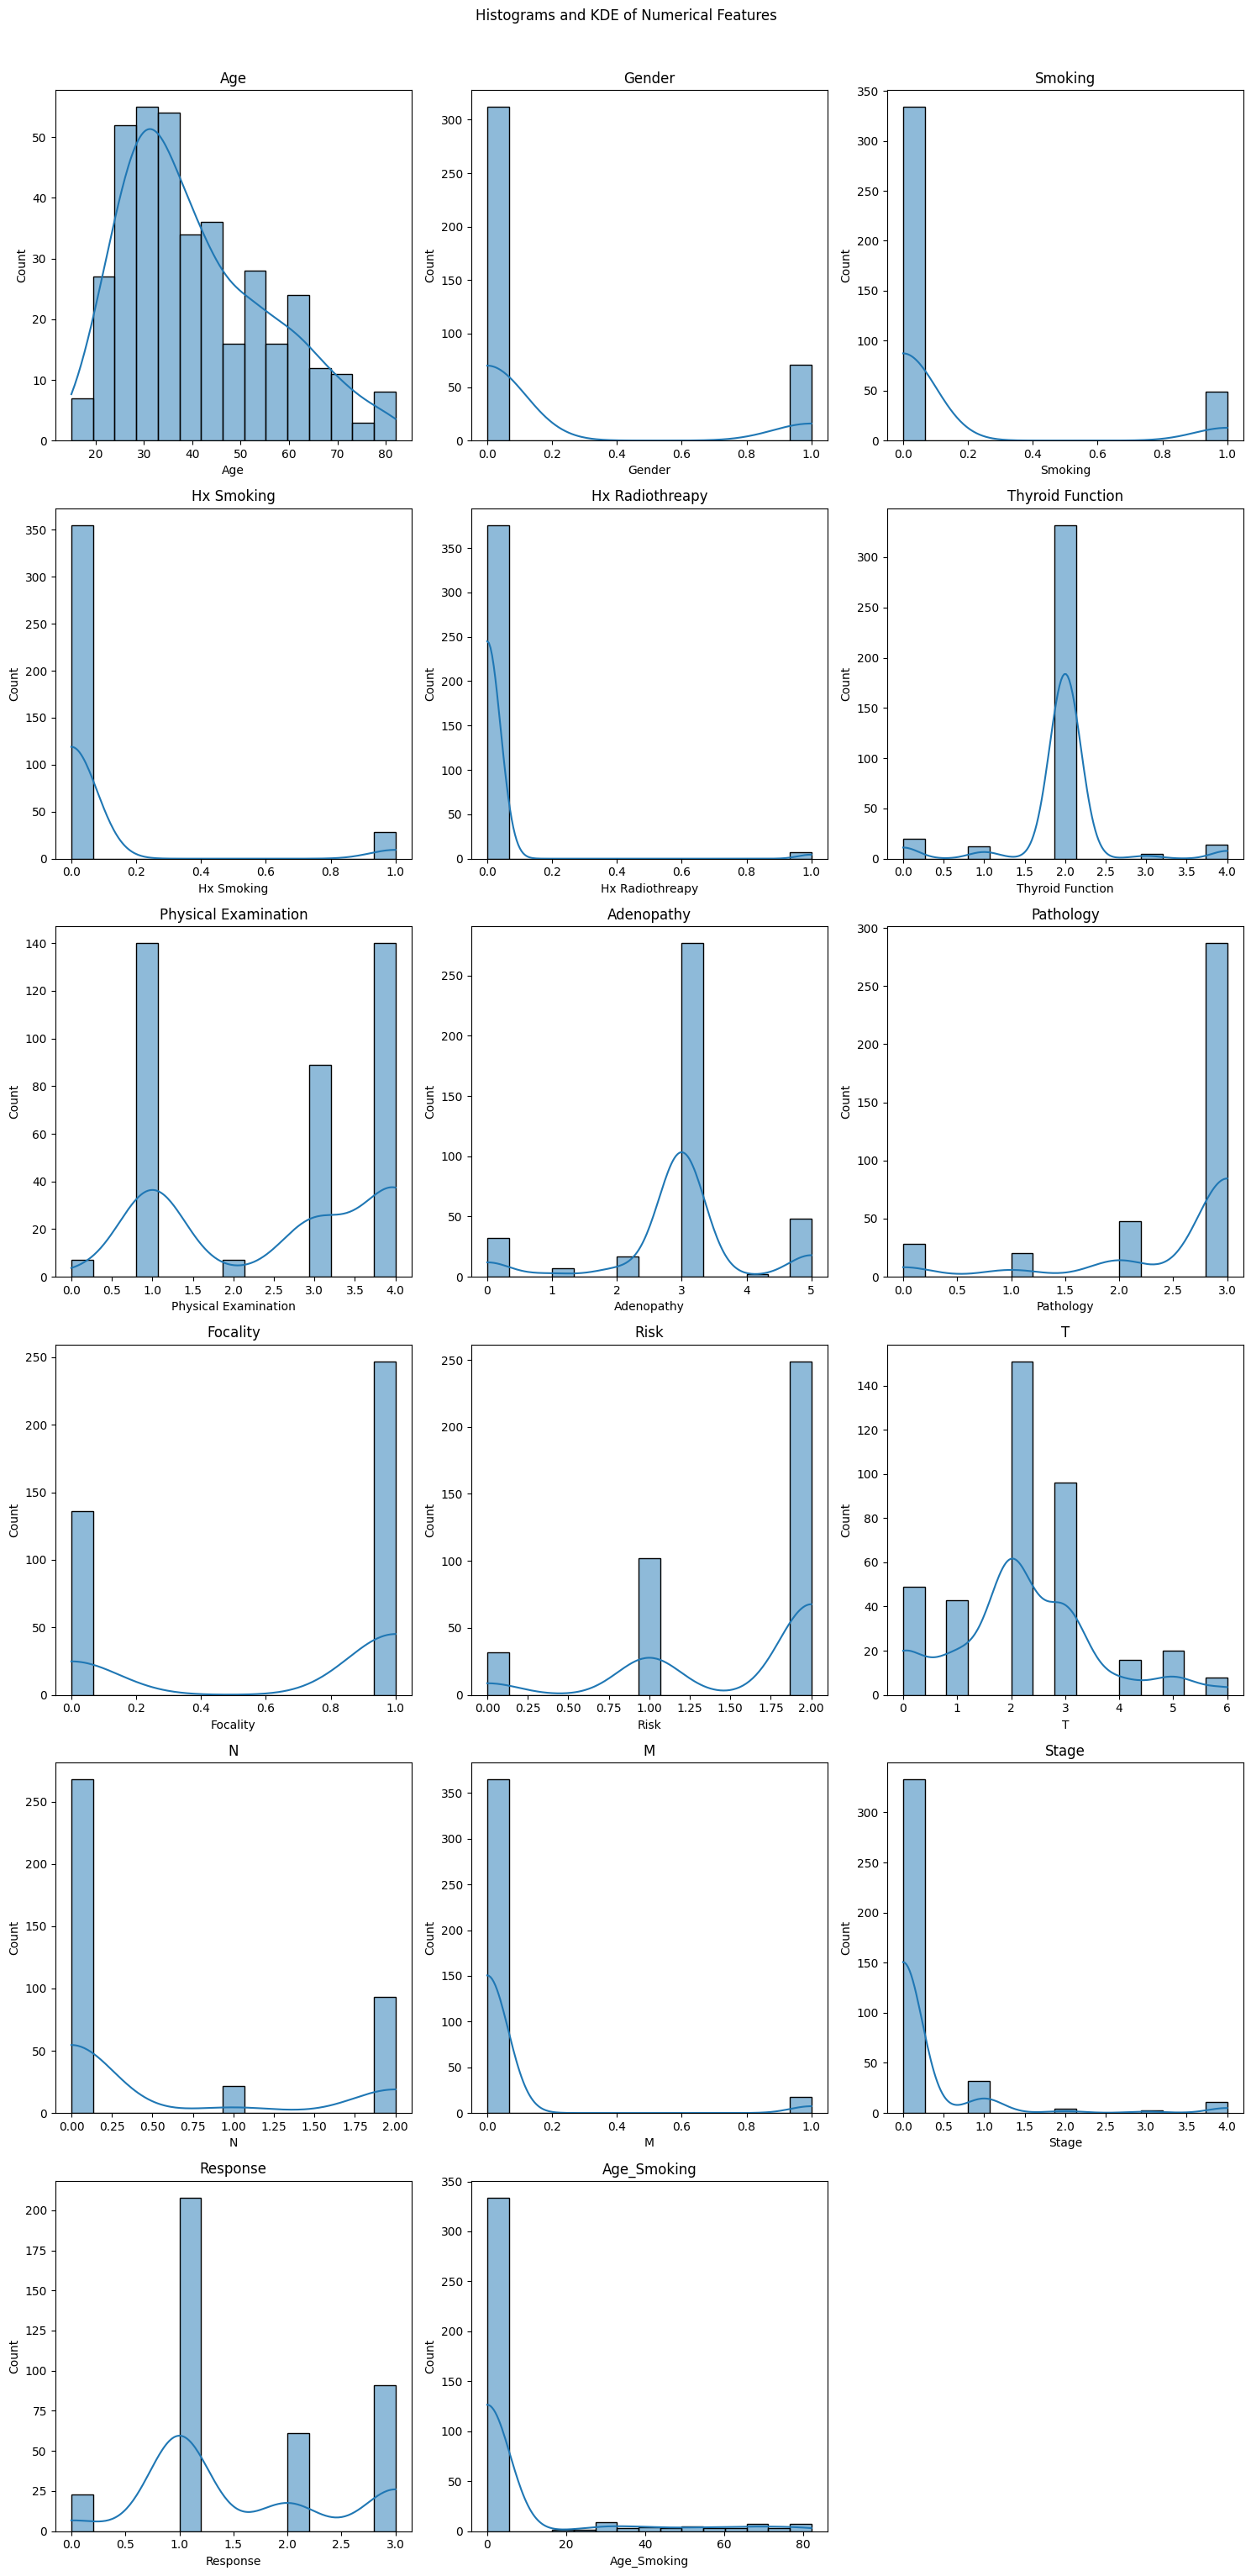

In [34]:
# Histograms with KDE plots
print("\n# Histograms and KDE of Numerical Features")
numerical_features = X.columns
num_features = len(numerical_features)
n_cols = 3
n_rows = (num_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data[feature], kde=True, bins=15)
    plt.title(feature)
plt.tight_layout()
plt.suptitle('Histograms and KDE of Numerical Features', y=1.02)
plt.show()




# ROC Curves with AUC


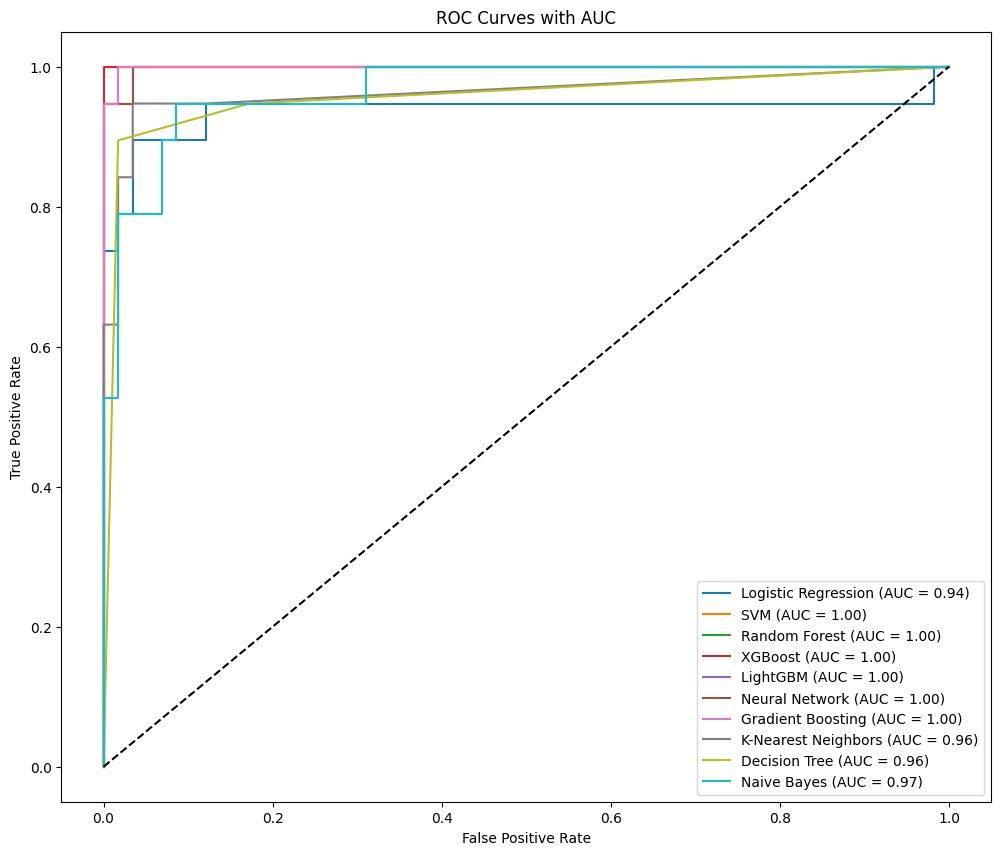

In [35]:
# ROC Curves
print("\n# ROC Curves with AUC")
plt.figure(figsize=(12, 10))
for name, result in results.items():
    if result['roc_auc'] != 'N/A':
        fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with AUC')
plt.legend(loc='best')
plt.show()




# Feature Importances for Best Model


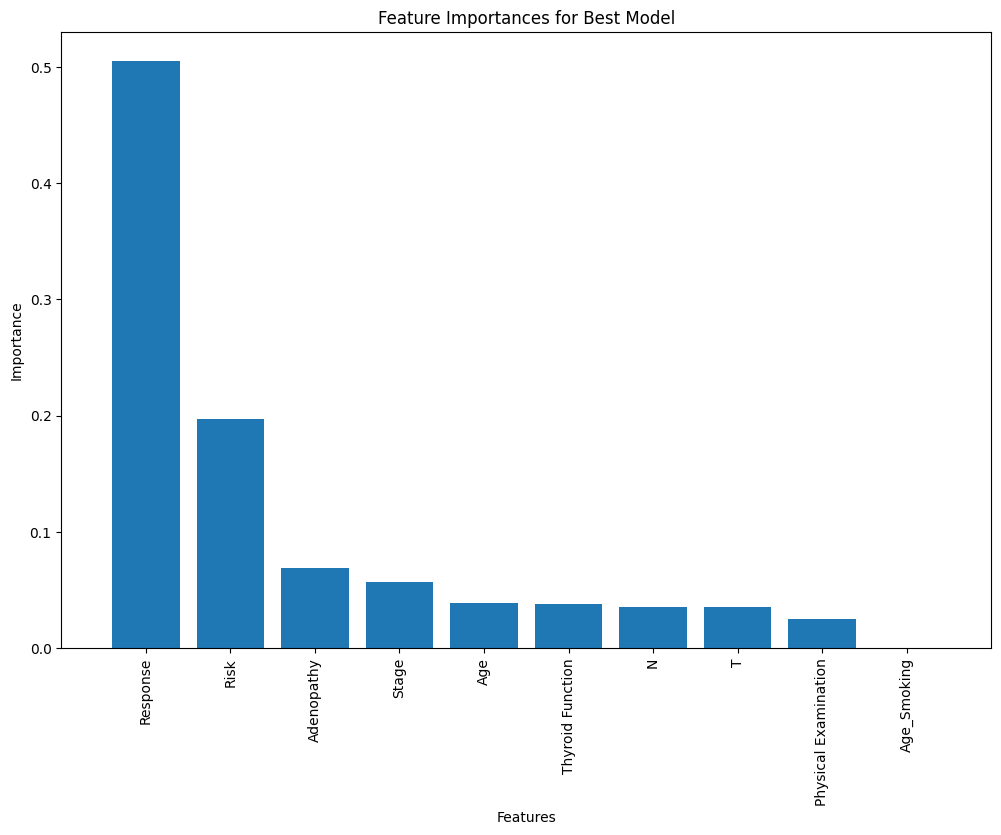


# PCA of Thyroid Cancer Dataset


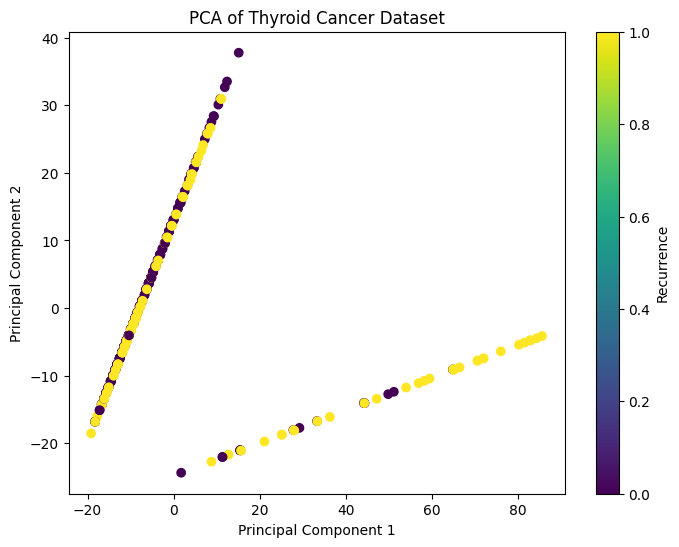

In [36]:
# Feature Importances
print("\n# Feature Importances for Best Model")
best_model = results[max(results, key=lambda x: results[x]['roc_auc'])]['model']
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances for Best Model')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [selected_features[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("The best model does not have feature importances.")

# PCA Plot
print("\n# PCA of Thyroid Cancer Dataset")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter, label='Recurrence')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Thyroid Cancer Dataset')
plt.show()

In [41]:
import pandas as pd

# Identify the Best Model
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model_result = results[best_model_name]

# Display Best Model Details
print(f"\n# Details of the Best Model: {best_model_name}")
print(f"Best Parameters: {best_model_result['best_params']}")
print(f"Accuracy: {best_model_result['accuracy']:.4f}")
print(f"ROC-AUC Score: {best_model_result['roc_auc']:.4f}")
print("\nClassification Report:")
print(pd.DataFrame(best_model_result['report']).transpose())

# Make a Sample Prediction with the Best Model
sample_index = 0  # You can choose any index or use a specific sample
sample_data = X_test[sample_index].reshape(1, -1)
sample_prediction = best_model_result['model'].predict(sample_data)

print(f"\nSample Prediction with Best Model: {sample_prediction}")




# Details of the Best Model: XGBoost
Best Parameters: {'n_estimators': 100, 'max_depth': 6}
Accuracy: 0.9870
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score    support
0              1.000000  0.982759  0.991304  58.000000
1              0.950000  1.000000  0.974359  19.000000
accuracy       0.987013  0.987013  0.987013   0.987013
macro avg      0.975000  0.991379  0.982832  77.000000
weighted avg   0.987662  0.987013  0.987123  77.000000

Sample Prediction with Best Model: [0]


In [43]:
import pandas as pd

# Generate a Comprehensive Report
print("\n# Generating Comprehensive Report")

# Dataset Summary
dataset_summary = {
    'Total Samples': [data.shape[0]],
    'Total Features': [data.shape[1]],
    'Target Variable': [target_column]
}

# Convert to DataFrame
dataset_summary_df = pd.DataFrame(dataset_summary)

# Model Performance Summary
model_performance_summary = {
    'Model': [],
    'Best Parameters': [],
    'Accuracy': [],
    'ROC-AUC Score': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, result in results.items():
    model_performance_summary['Model'].append(name)
    model_performance_summary['Best Parameters'].append(result['best_params'])
    model_performance_summary['Accuracy'].append(result['accuracy'])
    model_performance_summary['ROC-AUC Score'].append(result['roc_auc'])
    model_performance_summary['Precision'].append(result['report']['1']['precision'])
    model_performance_summary['Recall'].append(result['report']['1']['recall'])
    model_performance_summary['F1 Score'].append(result['report']['1']['f1-score'])

# Convert to DataFrame
model_performance_df = pd.DataFrame(model_performance_summary)

# Identify the Best Model
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model_result = results[best_model_name]

# Add Best Model Highlight
model_performance_df['Best Model'] = model_performance_df['Model'] == best_model_name

# Sort by ROC-AUC Score
model_performance_df = model_performance_df.sort_values(by='ROC-AUC Score', ascending=False).reset_index(drop=True)

# Combine All Sections into a Comprehensive Report
report = {
    'Dataset Summary': dataset_summary_df,
    'Model Performance Summary': model_performance_df
}

# Display the Report
for section_name, df in report.items():
    print(f"\n# {section_name}")
    print(df.to_string(index=False))

# Save the Report to a CSV File
report_df = pd.concat(report.values(), keys=report.keys(), names=['Section'])
report_df.to_csv('comprehensive_report.csv')
print("\n# Comprehensive report saved to 'comprehensive_report.csv'")

# Additional Information: Best Model Comparison
print(f"\n# Best Model Comparison")
print(f"Best Model: {best_model_name}")
print(f"Best Model Accuracy: {best_model_result['accuracy']:.4f}")
print(f"Best Model ROC-AUC Score: {best_model_result['roc_auc']:.4f}")

# Display Comparison with Other Models
print("\n# Comparison with Other Models")
for name, result in results.items():
    if name != best_model_name:
        print(f"\nModel: {name}")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"ROC-AUC Score: {result['roc_auc']:.4f}")



# Generating Comprehensive Report

# Dataset Summary
 Total Samples  Total Features Target Variable
           383              18        Recurred

# Model Performance Summary
              Model                                 Best Parameters  Accuracy  ROC-AUC Score  Precision   Recall  F1 Score  Best Model
            XGBoost           {'n_estimators': 100, 'max_depth': 6}  0.987013       1.000000   0.950000 1.000000  0.974359        True
      Random Forest          {'n_estimators': 100, 'max_depth': 20}  0.987013       0.999093   1.000000 0.947368  0.972973       False
  Gradient Boosting     {'n_estimators': 100, 'learning_rate': 0.1}  0.987013       0.999093   0.950000 1.000000  0.974359       False
                SVM                      {'kernel': 'rbf', 'C': 10}  0.987013       0.998185   1.000000 0.947368  0.972973       False
           LightGBM      {'n_estimators': 50, 'learning_rate': 0.1}  0.987013       0.998185   1.000000 0.947368  0.972973       False
     Neural N